#### 작업스케줄링 환경에서 모델을 학습시켜보는 코드입니다.
#### 자세한 사항은 docs/customEnv.md와 scheduler_env/customEnv.py를 참고해주세요

In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg
from stable_baselines3.common.env_checker import check_env

from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

In [2]:
from scheduler_env.customEnv import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

Resource x 8 , Order x 12 환경입니다
다른 환경에서 실험을 진행하고 싶다면 orders, resources 디렉토리를 참고해주세요

혹시 아래에서 오류가 발생할 경우 실행을 한 번 더 눌러주세요

In [5]:
env = SchedulingEnv(resources= "resources/v2-8.json", orders = "orders/v2-12-deadline.json")
check_env(env)

아래는 랜덤으로 스케줄링을 진행한 것 입니다.
각 지표의 의미는 customEnv.py 파일을 참고해주세요

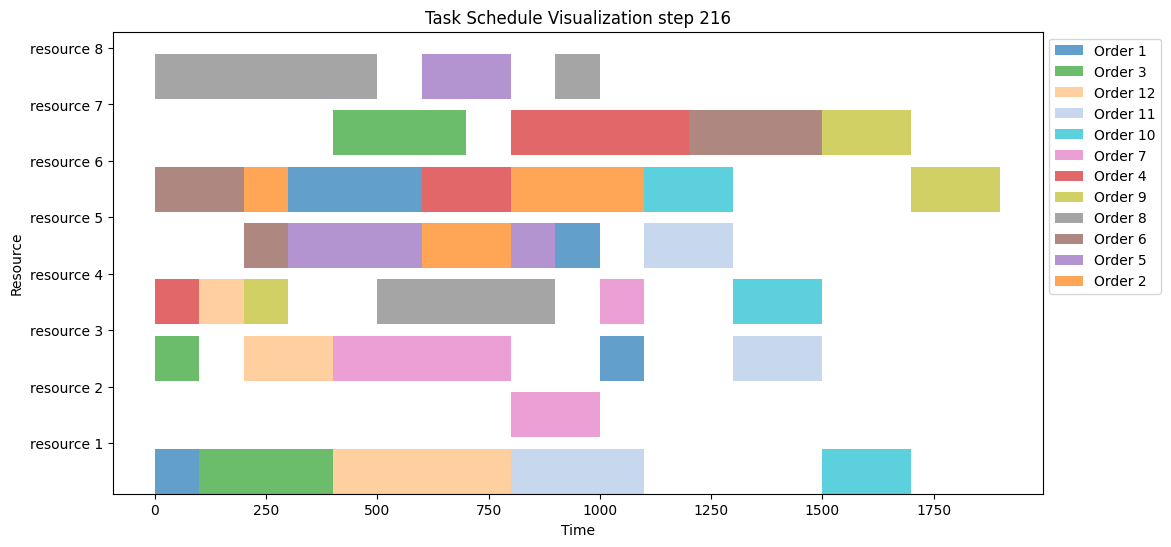

In [6]:
step = 0
obs, info = env.reset()

while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        # print("Goal reached!", "final score=", reward)
        # print('finish_time', info['finish_time'])
        # print('order_density', info['order_density'])
        # print('resource_operation_rate', info['resource_operation_rate'])
        # print('order_deadline', info['order_deadline'])
        # print('order_time_exceeded', info['order_time_exceeded'])
        env.render()
        break

PPO 모델을 해당 환경에서 1,000,000 step 만큼 학습시킵니다

In [7]:
model = PPO('MultiInputPolicy', env, verbose=1).learn(1000000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 202      |
|    ep_rew_mean     | -64      |
| time/              |          |
|    fps             | 1718     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 197         |
|    ep_rew_mean          | -62.5       |
| time/                   |             |
|    fps                  | 1373        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012729907 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss   

Goal reached! final score= 73.53174607148246
finish_time 1200
order_density [0.6666666666666666, 0.8571428571428571, 0.875, 0.6363636363636364, 1.0, 0.8571428571428571, 0.7, 0.8333333333333334, 1.0, 0.8571428571428571, 0.7, 1.0]
resource_operation_rate [0.9166666666666666, 0.75, 0.8333333333333334, 0.6666666666666666, 1.0, 0.6666666666666666, 0.8333333333333334, 1.0]
order_deadline [900, 900, 1050, 1050, 900, 900, 1050, 1500, 750, 900, 1050, 1050]
order_time_exceeded [0, 200, 0, 150, 0, 0, 0, 0, 150, 0, 0, 0]


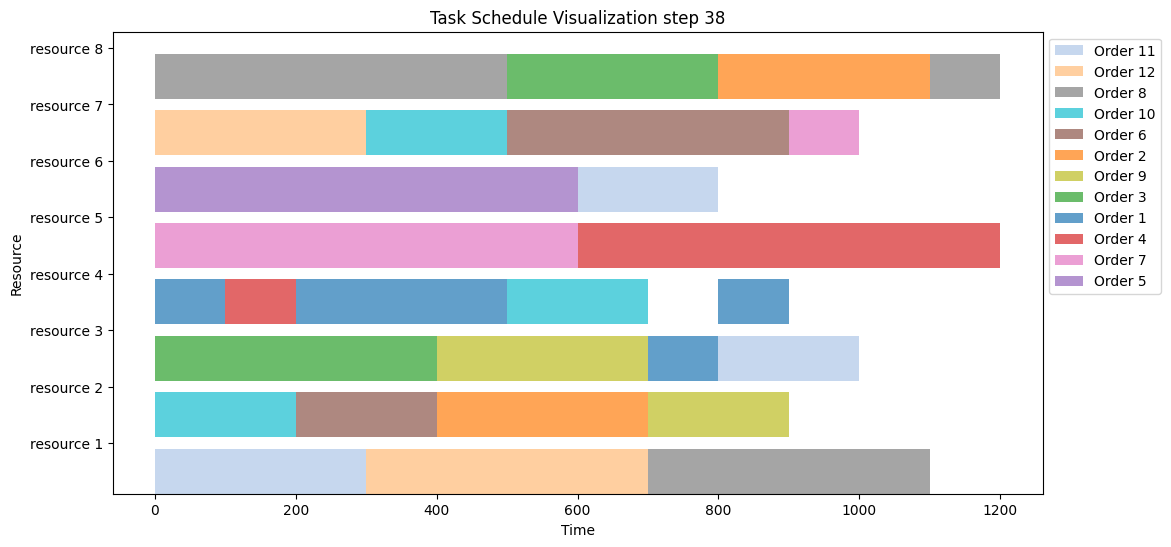

In [8]:
obs, info = env.reset()
done = False
while True:
    action, _ = model.predict(obs, deterministic = False)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('order_density', info['order_density'])
        print('resource_operation_rate', info['resource_operation_rate'])
        print('order_deadline', info['order_deadline'])
        print('order_time_exceeded', info['order_time_exceeded'])
        env.render()
        break

In [10]:
model.save("PPO_1,000,000_v2")